In [ ]:
 !pip install snowflake-snowpark-python
!pip install googletrans
!pip install snowflake-ml-python

ERROR: Operation cancelled by user


### Setup Connection

In [ ]:
from snowflake.snowpark import Session
import numpy as np
import pandas as pd
from googletrans import Translator
from snowflake.snowpark.functions import year, month
from snowflake.snowpark.functions import col,sum as sum_
from snowflake.snowpark.functions import count, lit
from snowflake.snowpark.types import IntegerType, FloatType, DoubleType, DecimalType, StringType, DateType, TimestampType, LongType
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import snowflake.ml.modeling.preprocessing as snowml

In [ ]:
connection_parameters = {
...    "account": "YEZEPEO-VNSHARED",
...    "user": "VNSHARED",
...    "password": "Stratify2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "VN_SHARED_DB", # optional
...   "schema": "PUBLIC" # optional
...  }

In [ ]:
connection_parameters = {
...    "account": "YEZEPEO-DATASCIENCE",
...    "user": "VNSHARED",
...    "password": "Columbia2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "MEIXI_DATA", # optional
...   "schema":"PUBLIC",  # optional
...  }

In [ ]:
new_session = Session.builder.configs(connection_parameters).create()

#### Join Vespucio and equifax data

In [ ]:
df_consolidated=new_session.sql('select * from PUBLIC.TBPAGOS_DOCUMENTOSCOBRO_CONSOLIDADOEXTENDIDO_TS_SHARED')
df_equifax=new_session.sql('select * from PUBLIC.EQUIFAX_SHARED')

In [ ]:
df_consolidated=new_session.sql('select * from PUBLIC.CONSOLIDATED_COPY')
df_equifax=new_session.sql('select * from PUBLIC.EQUIFAX_COPY')

In [ ]:
# Finding Common columns
common_cols = np.intersect1d(df_consolidated.columns, df_equifax.columns)

# Printing common columns
print ("Common Columns:",common_cols)

Common Columns: ['"FechaExtraccion"' 'RUT']


In [ ]:
df_con_equifax=df_consolidated.join(df_equifax.select('"RUT"', '"Score Equifax"'), on='"RUT"', how='left')

In [ ]:
df_con_equifax = df_con_equifax.with_column("YEAR_DUE", year(col('"FechaVencimiento"')))\
                          .with_column("MONTH_DUE", month(col('"FechaVencimiento"')))

df_con_equifax = df_con_equifax.with_column("YEAR_PAID", year(col('"FechaCompensacion"')))\
                          .with_column("MONTH_PAID", month(col('"FechaCompensacion"')))

df_con_equifax = df_con_equifax.with_column("YEAR_INVOICED", year(col('"FechaEmision"')))\
                          .with_column("MONTH_INVOICED", month(col('"FechaEmision"')))

In [ ]:
df_con_equifax.columns

['RUT',
 '"FechaExtraccion"',
 '"NumeroDocumento"',
 '"NumeroFolio"',
 '"FechaEmision"',
 '"FechaVencimiento"',
 '"FechaRegistro"',
 '"BusinessPartnerId"',
 '"CuentaContrato"',
 '"ClaveReconciliacion"',
 '"Cabecera_FechaHoraCreacion"',
 '"Cabecera_FechaHoraUltimaModificacion"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 '"Detalle_FechaHoraCreacion"',
 '"Detalle_FechaHoraUltimaModificacion"',
 '"Direccion"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"Nombre"',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"StatusCompensacionTmp"',
 '"Score Equifax"',
 'YEAR_DUE',
 'MONTH_DUE',
 'YEAR_PAID',
 'MONTH_PAID',
 'YEAR_INVOICED',
 'MONTH_INVOICED']

In [ ]:
from snowflake.snowpark.functions import desc, asc
df_con_equifax = df_con_equifax.orderBy(desc('YEAR_DUE'))
df_con_equifax.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"       |"FechaExtraccion"          

In [ ]:
df_con_equifax = df_con_equifax.filter(df_con_equifax["YEAR_DUE"] != 2024)
df_con_equifax = df_con_equifax.filter(df_con_equifax["YEAR_DUE"] != 2023)
df_con_equifax.show(5)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"       |"FechaExtraccion

#### Shape of the datasets

In [ ]:
def dataset_shape(df):
    # Get the number of rows
    num_rows = df.count()
    # Get the number of columns
    num_columns = len(df.columns)
    # Shape of the DataFrame
    shape = (num_rows, num_columns)
    print("Shape of the given dataset", shape)

In [ ]:
dataset_shape(df_con_equifax)

Shape of the given dataset (425616671, 46)


In [ ]:
dataset_shape(df_equifax)

Shape of the given dataset (3537839, 7)


In [ ]:
dataset_shape(df_consolidated)

Shape of the given dataset (482705441, 39)


#### Missing Values

In [ ]:
def missing_values(df):
# Assuming 'df' is your DataFrame
    # Get the total number of rows
    total_rows = df.count()

    missing_percentages = df.select(
        [(100 - (count(c) / lit(total_rows) * 100)).alias(c) for c in df.columns]
    )

    # Show the results
    missing_percentages.show()

In [ ]:
missing_values(df_con_equifax)

KeyboardInterrupt: 

#### Drop unique identifiers from the joined dataset for EDA & visualization purposes

In [ ]:
df_con_equifax.show(5)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"       |"FechaExtraccion"

In [ ]:
from snowflake.snowpark.functions import when, col
df_con_equifax = df_con_equifax.withColumn('Unpaid', when(col('"StatusCompensacion"') == 'Impaga', 1).otherwise(0))
df_con_equifax.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
dataset_shape(df_con_equifax)

Shape of the given dataset (482705441, 47)


In [ ]:
# Group by the column and count the occurrences of each unique value
count_distinct_types = df_con_equifax.groupBy('RUT', 'Score Equifax', 'YEAR_INVOICED' ).agg(count("*").alias("count"))

# Show the results
count_distinct_types.show()

------------------------------------------------------------
|"RUT"       |"Score Equifax"  |"YEAR_INVOICED"  |"COUNT"  |
------------------------------------------------------------
|9786050-5   |562.0            |2021             |85       |
|78874090-5  |999.0            |2017             |809      |
|11827139-4  |31.0             |2023             |22       |
|76111977-K  |1.0              |2019             |65       |
|17781953-0  |672.0            |2014             |36       |
|10987444-2  |404.0            |2019             |41       |
|6742035-7   |790.0            |2023             |14       |
|11893306-0  |797.0            |2014             |8        |
|76106736-2  |7.0              |2014             |30       |
|7445135-7   |480.0            |2019             |9        |
------------------------------------------------------------



In [ ]:
from snowflake.snowpark.functions import collect_set, count

df_unique_rut = (
    df_con_equifax
    .groupBy("RUT", "Score Equifax", 'YEAR_INVOICED')
    .agg(
        collect_set('"NumeroDocumento"').alias("NumeroDocumentoList"),
        count(when(df_con_equifax["Unpaid"] == 1, True)).alias("UnpaidCount")
    )
)
df_unique_rut.show(5)

---------------------------------------------------------------------------------------------
|"RUT"       |"Score Equifax"  |"YEAR_INVOICED"  |"NUMERODOCUMENTOLIST"     |"UNPAIDCOUNT"  |
---------------------------------------------------------------------------------------------
|10770803-0  |776.0            |2017             |[                         |0              |
|            |                 |                 |  1.920154414900000e+10,  |               |
|            |                 |                 |  5.650058735800000e+10,  |               |
|            |                 |                 |  5.960147514600000e+10,  |               |
|            |                 |                 |  5.470048115500000e+10,  |               |
|            |                 |                 |  5.620049548300000e+10,  |               |
|            |                 |                 |  1.920154415000000e+10,  |               |
|            |                 |                 |  5.470048

In [ ]:
from snowflake.snowpark.functions import collect_set, count

df_unique_rut_2 = (
    df_con_equifax
    .groupBy("RUT", "Score Equifax")
    .agg(
        collect_set('"NumeroDocumento"').alias("NumeroDocumentoList"),
        count(when(df_con_equifax["Unpaid"] == 1, True)).alias("UnpaidCount")
    )
)
dataset_shape(df_unique_rut_2)

Shape of the given dataset (3849283, 4)


In [ ]:
from snowflake.snowpark.functions import collect_set

df_unique_rut = (
    df_con_equifax
    .groupBy("RUT", 'Score Equifax')
    .agg(
        collect_set('"NumeroDocumento"').alias("NumeroDocumentoList")
    )
)
# Show the resulting DataFrame
df_unique_rut.show(5)

-----------------------------------------------------------
|"RUT"       |"Score Equifax"  |"NUMERODOCUMENTOLIST"     |
-----------------------------------------------------------
|13265155-8  |46.0             |[                         |
|            |                 |  9.720005828160000e+11,  |
|            |                 |  6.080239356600000e+10,  |
|            |                 |  5.515108073700000e+10,  |
|            |                 |  5.545115783400000e+10,  |
|            |                 |  5.650102292400000e+10,  |
|            |                 |  9.717003303960000e+11,  |
|            |                 |  9.719004913310000e+11,  |
|            |                 |  9.720005828150000e+11,  |
|            |                 |  5.545115783500000e+10,  |
|            |                 |  9.726004756850000e+11,  |
|            |                 |  1.920189618700000e+10,  |
|            |                 |  5.785135671800000e+10,  |
|            |                 |  6.5202

In [ ]:
df_con_equifax.show(5)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"       |"FechaExtr

# Clustering

In [ ]:
df_con_equifax.columns

['RUT',
 '"FechaExtraccion"',
 '"NumeroDocumento"',
 '"NumeroFolio"',
 '"FechaEmision"',
 '"FechaVencimiento"',
 '"FechaRegistro"',
 '"BusinessPartnerId"',
 '"CuentaContrato"',
 '"ClaveReconciliacion"',
 '"Cabecera_FechaHoraCreacion"',
 '"Cabecera_FechaHoraUltimaModificacion"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 '"Detalle_FechaHoraCreacion"',
 '"Detalle_FechaHoraUltimaModificacion"',
 '"Direccion"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"Nombre"',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"StatusCompensacionTmp"',
 '"Score Equifax"',
 'YEAR_DUE',
 'MONTH_DUE',
 'YEAR_PAID',
 'MONTH_PAID',
 'YEAR_INVOICED',
 'MONTH_INVOICED',
 'UNPAID']

In [ ]:
# Assuming col() is a function that retrieves the specified column
# Replace col() with df_with_avg['column_name'] if col() doesn't represent your data retrieval method

df_con_equifax = df_con_equifax.with_column("CantidadCuentasContrato", col('"CantidadCuentasContrato"'))
df_con_equifax = df_con_equifax.with_column("Inhabilitado", col('"Inhabilitado"'))
df_con_equifax = df_con_equifax.with_column("Concesionaria", col('"Concesionaria"'))
df_con_equifax = df_con_equifax.with_column("TipoCliente", col('"TipoCliente"'))
df_con_equifax = df_con_equifax.with_column("TipoOperacion", col('"TipoOperacion"'))
df_con_equifax = df_con_equifax.with_column("Score_Equifax", col('"Score Equifax"'))
df_con_equifax = df_con_equifax.with_column("ImportePesos", col('"ImportePesos"'))
df_con_equifax = df_con_equifax.with_column("CantidadVehiculos", col('"CantidadVehiculos"'))


In [ ]:
df_con_equifax.columns

['RUT',
 '"FechaExtraccion"',
 '"NumeroDocumento"',
 '"NumeroFolio"',
 '"FechaEmision"',
 '"FechaVencimiento"',
 '"FechaRegistro"',
 '"BusinessPartnerId"',
 '"CuentaContrato"',
 '"ClaveReconciliacion"',
 '"Cabecera_FechaHoraCreacion"',
 '"Cabecera_FechaHoraUltimaModificacion"',
 '"PosicionDocumento"',
 '"ImportePesos"',
 '"DocumentoCompensacion"',
 '"FechaCompensacion"',
 '"DiasCompensacion"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 '"Detalle_FechaHoraCreacion"',
 '"Detalle_FechaHoraUltimaModificacion"',
 '"Direccion"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"Nombre"',
 '"CantidadCuentasContrato"',
 '"MaxCategoriaVehiculo"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 '"StatusCompensacion"',
 '"StatusCompensacionTmp"',
 '"Score Equifax"',
 'YEAR_DUE',
 'MONTH_DUE',
 'YEAR_PAID',
 'MONTH_PAID',
 'YEAR_INVOICED',
 'MONTH_INVOICED',
 'UNPAID',
 'CANT

In [ ]:
variables = ['REGION',
 'UNPAID',
 'CANTIDADCUENTASCONTRATO',
 'INHABILITADO',
 'CONCESIONARIA',
 'TIPOCLIENTE',
 'TIPOOPERACION',
 'SCORE_EQUIFAX',
 'IMPORTEPESOS',
 'CANTIDADVEHICULOS']

In [ ]:
import snowflake.snowpark.functions as f

In [ ]:
variables = ['REGION', 'CANTIDADCUENTASCONTRATO', 'INHABILITADO', 'CONCESIONARIA', 'TIPOCLIENTE', 'TIPOOPERACION']

for col in variables:
    distinct_values = df_con_equifax.select(col).distinct().collect()
    for value in distinct_values:
        value_col = f"{col}_{value[col]}"
        df_con_equifax = df_con_equifax.with_column(value_col, f.when(df_con_equifax[col] == value[col], 1).otherwise(0).cast("int"))

In [ ]:
columns_to_drop = ['"FechaExtraccion"',
                   '"NumeroDocumento"',
                   '"NumeroFolio"',
                   '"FechaEmision"',
                   '"FechaVencimiento"',
                   '"FechaRegistro"',
                   '"BusinessPartnerId"',
                   '"CuentaContrato"',
                   '"ClaveReconciliacion"',
                   '"Cabecera_FechaHoraCreacion"',
                   '"Cabecera_FechaHoraUltimaModificacion"',
                   '"PosicionDocumento"',
                   '"ImportePesos"',
                   '"DocumentoCompensacion"',
                   '"FechaCompensacion"',
                   '"DiasCompensacion"',
                   '"OperacionPrincipal"',
                   '"OperacionParcial"',
                   '"Detalle_FechaHoraCreacion"',
                   '"Detalle_FechaHoraUltimaModificacion"',
                   '"Direccion"',
                   'COMUNA',
                   'CIUDAD',
                   'REGION',
                   '"Nombre"',
                   '"CantidadCuentasContrato"',
                   '"MaxCategoriaVehiculo"',
                   '"CantidadVehiculos"',
                   '"TramoMoraCliente"',
                   '"TramoMora"',
                   '"Inhabilitado"',
                   '"Concesionaria"',
                   '"TipoCliente"',
                   '"TipoOperacion"',
                   '"TipoDocumento"',
                   '"TipoProducto"',
                   '"StatusCompensacion"',
                   '"StatusCompensacionTmp"',
                   '"Score Equifax"',
                   'YEAR_DUE',
                   'MONTH_DUE',
                   'YEAR_PAID',
                   'MONTH_PAID',
                   'YEAR_INVOICED',
                   'MONTH_INVOICED',
                   'CANTIDADCUENTASCONTRATO',
                   'INHABILITADO',
                   'CONCESIONARIA',
                   'TIPOCLIENTE',
                   'TIPOOPERACION']

df_con_equifax = df_con_equifax.drop(*columns_to_drop)

In [ ]:
L = df_con_equifax.columns
print(L)
L = L[1:]
print(L)

['RUT', 'UNPAID', 'SCORE_EQUIFAX', 'IMPORTEPESOS', 'CANTIDADVEHICULOS', 'REGION_12', 'REGION_04', 'REGION_01', 'REGION_02', 'REGION_05', 'REGION_06', 'REGION_03', 'REGION_15', 'REGION_NONE', 'REGION_07', 'REGION_16', '"REGION_ "', 'REGION_08', 'REGION_14', 'REGION_09', 'REGION_13', 'REGION_10', 'REGION_11', '"COMUNA_LA FLORIDA"', 'COMUNA_RECOLETA', 'COMUNA_MARIQUINA', 'COMUNA_ILLAPEL', '"COMUNA_QUINTA NORMAL"', 'COMUNA_CATEMU', 'COMUNA_SANTIAGO', '"COMUNA_LA GRANJA"', 'COMUNA_TEMUCO', 'COMUNA_CHIGUAYANTE', '"COMUNA_PUNTA ARENAS"', 'COMUNA_PANQUEHUE', '"COMUNA_SAN JAVIER"', 'COMUNA_COQUIMBO', 'COMUNA_CAUQUENES', 'COMUNA_CARTAGENA', '"COMUNA_LAS CABRAS"', '"COMUNA_ALTO HOSPICIO"', 'COMUNA_HIJUELAS', '"COMUNA_PUERTO OCTAY"', 'COMUNA_CALBUCO', 'COMUNA_LONCOCHE', 'COMUNA_RAUCO', 'COMUNA_MALLOA', '"COMUNA_ÑIQUEN"', '"COMUNA_¿CONCÓN"', 'COMUNA_LITUECHE', 'COMUNA_PEMUCO', 'COMUNA_CHOLCHOL', '"COMUNA_TORRES DEL PAINE"', 'COMUNA_GUAITECAS', 'COMUNA_ELQUI', '"COMUNA_VINA DEL MAR"', 'COMUNA_VITACU

In [ ]:
grouped_df = df_con_equifax.groupBy('RUT') \
                            .agg(*[f.avg(variable).alias(variable) for variable in L])

In [ ]:
dataset_shape(grouped_df)

Shape of the given dataset (3849283, 536)


In [ ]:
from snowflake.ml.modeling.cluster  import KMeans

In [ ]:
grouped_df_t = grouped_df.limit(1000)

In [ ]:
dataset_shape(grouped_df_t)

Shape of the given dataset (1000, 535)


In [ ]:
grouped_df_t.show(5)

KeyboardInterrupt: 

In [ ]:
# Select the columns you want to use for clustering
feature_cols = [col for col in grouped_df_t.columns if col != 'RUT']

# Combine the feature columns into a single vector column
assembled_data = grouped_df_t.select('RUT', f.concat(*feature_cols).alias('features'))


In [ ]:
assembled_data.show(5)

KeyboardInterrupt: 

In [ ]:

# Create the K-Means model
kmeans = KMeans(n_clusters=5)

# Fit the model
model = kmeans.fit(assembled_data)

# Assign cluster labels to the data
clustered_df = model.transform(assembled_data)

KeyboardInterrupt: 

# Using pandas to cluster

In [ ]:
df_con_equifax.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_con_equifax.columns

['RUT',
 'UNPAID',
 'SCORE_EQUIFAX',
 'IMPORTEPESOS',
 'CANTIDADVEHICULOS',
 'REGION_12',
 'REGION_04',
 'REGION_02',
 'REGION_01',
 'REGION_05',
 'REGION_06',
 'REGION_03',
 'REGION_15',
 'REGION_07',
 'REGION_16',
 '"REGION_ "',
 'REGION_09',
 'REGION_08',
 'REGION_14',
 'REGION_13',
 'REGION_11',
 'REGION_10',
 'CANTIDADCUENTASCONTRATO_1',
 'CANTIDADCUENTASCONTRATO_5',
 'CANTIDADCUENTASCONTRATO_10',
 'CANTIDADCUENTASCONTRATO_7',
 'CANTIDADCUENTASCONTRATO_14',
 'CANTIDADCUENTASCONTRATO_23',
 'CANTIDADCUENTASCONTRATO_19',
 'CANTIDADCUENTASCONTRATO_4',
 'CANTIDADCUENTASCONTRATO_9',
 'CANTIDADCUENTASCONTRATO_33',
 'CANTIDADCUENTASCONTRATO_20',
 'CANTIDADCUENTASCONTRATO_13',
 'CANTIDADCUENTASCONTRATO_40',
 'CANTIDADCUENTASCONTRATO_15',
 'CANTIDADCUENTASCONTRATO_21',
 'CANTIDADCUENTASCONTRATO_17',
 'CANTIDADCUENTASCONTRATO_6',
 'CANTIDADCUENTASCONTRATO_12',
 'CANTIDADCUENTASCONTRATO_8',
 'CANTIDADCUENTASCONTRATO_3',
 'CANTIDADCUENTASCONTRATO_2',
 'CANTIDADCUENTASCONTRATO_60',
 'CANTIDADCU

In [ ]:
# from snowflake.snowpark.functions import desc, asc
# df_con_equifax_v_dt = df_filtered.orderBy(asc('"YEAR_DUE"'))

In [ ]:
df_con_equifax_t = df_con_equifax.limit(1000000)
df_con_equifax_pd = df_con_equifax_t.to_pandas()

In [ ]:
print(df_con_equifax_pd.columns)

Index(['RUT', 'UNPAID', 'SCORE_EQUIFAX', 'IMPORTEPESOS', 'CANTIDADVEHICULOS',
       'REGION_12', 'REGION_04', 'REGION_02', 'REGION_01', 'REGION_05',
       'REGION_06', 'REGION_03', 'REGION_15', 'REGION_07', 'REGION_16',
       'REGION_ ', 'REGION_09', 'REGION_08', 'REGION_14', 'REGION_13',
       'REGION_11', 'REGION_10', 'CANTIDADCUENTASCONTRATO_1',
       'CANTIDADCUENTASCONTRATO_5', 'CANTIDADCUENTASCONTRATO_10',
       'CANTIDADCUENTASCONTRATO_7', 'CANTIDADCUENTASCONTRATO_14',
       'CANTIDADCUENTASCONTRATO_23', 'CANTIDADCUENTASCONTRATO_19',
       'CANTIDADCUENTASCONTRATO_4', 'CANTIDADCUENTASCONTRATO_9',
       'CANTIDADCUENTASCONTRATO_33', 'CANTIDADCUENTASCONTRATO_20',
       'CANTIDADCUENTASCONTRATO_13', 'CANTIDADCUENTASCONTRATO_40',
       'CANTIDADCUENTASCONTRATO_15', 'CANTIDADCUENTASCONTRATO_21',
       'CANTIDADCUENTASCONTRATO_17', 'CANTIDADCUENTASCONTRATO_6',
       'CANTIDADCUENTASCONTRATO_12', 'CANTIDADCUENTASCONTRATO_8',
       'CANTIDADCUENTASCONTRATO_3', 'CANTIDADCUE

In [ ]:
# Create a helper function to remove leading/trailing double quotes
def remove_quotes(col_name):
    return col_name.strip('"')

# Rename the columns to remove leading/trailing double quotes
df_con_equifax_pd.columns = [remove_quotes(col) for col in df_con_equifax_pd.columns]


In [ ]:
L = df_con_equifax_pd.columns
print(L)
L = L[1:]
print(L)

Index(['RUT', 'UNPAID', 'SCORE_EQUIFAX', 'IMPORTEPESOS', 'CANTIDADVEHICULOS',
       'REGION_12', 'REGION_04', 'REGION_02', 'REGION_01', 'REGION_05',
       'REGION_06', 'REGION_03', 'REGION_15', 'REGION_07', 'REGION_16',
       'REGION_ ', 'REGION_09', 'REGION_08', 'REGION_14', 'REGION_13',
       'REGION_11', 'REGION_10', 'CANTIDADCUENTASCONTRATO_1',
       'CANTIDADCUENTASCONTRATO_5', 'CANTIDADCUENTASCONTRATO_10',
       'CANTIDADCUENTASCONTRATO_7', 'CANTIDADCUENTASCONTRATO_14',
       'CANTIDADCUENTASCONTRATO_23', 'CANTIDADCUENTASCONTRATO_19',
       'CANTIDADCUENTASCONTRATO_4', 'CANTIDADCUENTASCONTRATO_9',
       'CANTIDADCUENTASCONTRATO_33', 'CANTIDADCUENTASCONTRATO_20',
       'CANTIDADCUENTASCONTRATO_13', 'CANTIDADCUENTASCONTRATO_40',
       'CANTIDADCUENTASCONTRATO_15', 'CANTIDADCUENTASCONTRATO_21',
       'CANTIDADCUENTASCONTRATO_17', 'CANTIDADCUENTASCONTRATO_6',
       'CANTIDADCUENTASCONTRATO_12', 'CANTIDADCUENTASCONTRATO_8',
       'CANTIDADCUENTASCONTRATO_3', 'CANTIDADCUE

In [ ]:
# Group the data by 'RUT' and 'SCORE_EQUIFAX'
grouped = df_con_equifax_pd.groupby(['RUT'])

# Calculate the average for each variable in the grouped data
grouped_df = grouped.agg({var: 'mean' for var in L})


In [ ]:
grouped_df.head()

,UNPAID,SCORE_EQUIFAX,IMPORTEPESOS,CANTIDADVEHICULOS,REGION_12,REGION_04,REGION_02,REGION_01,REGION_05,REGION_06,...,CANTIDADCUENTASCONTRATO_11,INHABILITADO_Cliente Tag,INHABILITADO_INHABILITADO,CONCESIONARIA_AVN,CONCESIONARIA_TSC,TIPOCLIENTE_NATURAL,TIPOCLIENTE_JURIDICO,TIPOOPERACION_INTERESES,TIPOOPERACION_Gastos Cobranzas,TIPOOPERACION_PEAJE
RUT,,,,,,,,,,,,,,,,,,,,,
10000074-1,0.0,448.0,1833.333333,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.666667,0.333333,1.0,0.0,0.0,0.0,1.0
10000738-K,0.0,553.0,1598.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,0.000000,1.0,0.0,0.0,0.0,1.0
10000832-7,0.0,351.0,5.500000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,0.000000,1.0,0.0,1.0,0.0,0.0
10000938-2,1.0,570.0,8789.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,0.000000,1.0,0.0,0.0,0.0,1.0
10001147-6,0.5,422.0,1565.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,0.000000,1.0,0.0,0.0,0.0,1.0


In [49]:
len(grouped_df)

280637

In [ ]:
grouped_df.to_csv("/content/drive/MyDrive/grouped_df_3.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import pandas as pd
grouped_df = pd.read_csv("/content/drive/MyDrive/grouped_df_3.csv")
grouped_df.head()

,RUT,UNPAID,SCORE_EQUIFAX,IMPORTEPESOS,CANTIDADVEHICULOS,REGION_12,REGION_04,REGION_02,REGION_01,REGION_05,...,CANTIDADCUENTASCONTRATO_11,INHABILITADO_Cliente Tag,INHABILITADO_INHABILITADO,CONCESIONARIA_AVN,CONCESIONARIA_TSC,TIPOCLIENTE_NATURAL,TIPOCLIENTE_JURIDICO,TIPOOPERACION_INTERESES,TIPOOPERACION_Gastos Cobranzas,TIPOOPERACION_PEAJE
0,10000074-1,0.0,448.0,1833.333333,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.666667,0.333333,1.0,0.0,0.0,0.0,1.0
1,10000738-K,0.0,553.0,1598.666667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,0.000000,1.0,0.0,0.0,0.0,1.0
2,10000832-7,0.0,351.0,5.500000,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,0.000000,1.0,0.0,1.0,0.0,0.0
3,10000938-2,1.0,570.0,8789.000000,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,0.000000,1.0,0.0,0.0,0.0,1.0
4,10001147-6,0.5,422.0,1565.500000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,0.000000,1.0,0.0,0.0,0.0,1.0


In [50]:
grouped_df['UNPAID'].mean()

0.2015708229123612

Calculating metrics:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Calculating metrics:   8%|▊         | 1/12 [00:22<04:03, 22.10s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Calculating metrics:  17%|█▋        | 2/12 [00:43<03:35, 21.56s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Calculating metrics:  25%|██▌       | 3/12 [01:07<03:24, 22.76s/it]/usr/local/lib/python3.10/dist-packages/s

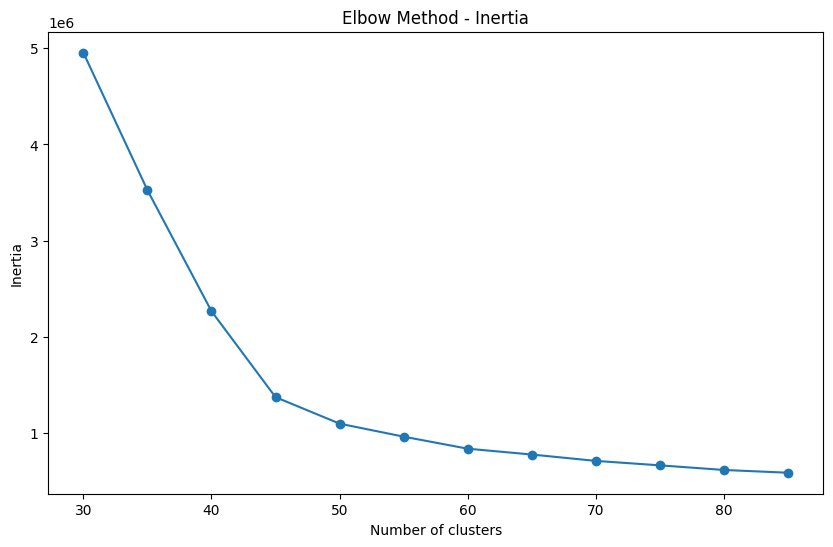

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

grouped_df = grouped_df.dropna(how='any', axis=0)
X = grouped_df.drop(['UNPAID'], axis=1)  # Features
y = grouped_df['UNPAID']  # Target variable
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method to find the optimal number of clusters
inertia = []
silhouette_scores = []

for k in tqdm(range(30, 90, 5), desc='Calculating metrics'):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(30, 90, 5), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - Inertia')
plt.show()


In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
grouped_df= grouped_df.dropna(how='any', axis=0)

X = grouped_df.drop(['UNPAID', 'RUT'], axis=1)  # Features
y = grouped_df['UNPAID']  # Target variable


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_scaled)

# Add cluster labels to the dataset
grouped_df['cluster_label'] = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [54]:
import pandas as pd

# Get the cluster counts and percentages
cluster_counts = grouped_df['cluster_label'].value_counts()
total_observations = len(grouped_df)

# Print the cluster counts and percentages
for cluster, count in cluster_counts.items():
    percentage = (count / total_observations) * 100
    print(f"Cluster {cluster}: Count = {count}, Percentage = {percentage:.2f}%")

Cluster 0: Count = 110197, Percentage = 40.88%
Cluster 1: Count = 46122, Percentage = 17.11%
Cluster 9: Count = 45041, Percentage = 16.71%
Cluster 8: Count = 28498, Percentage = 10.57%
Cluster 2: Count = 24454, Percentage = 9.07%
Cluster 5: Count = 14168, Percentage = 5.26%
Cluster 7: Count = 867, Percentage = 0.32%
Cluster 3: Count = 115, Percentage = 0.04%
Cluster 4: Count = 74, Percentage = 0.03%
Cluster 6: Count = 1, Percentage = 0.00%


In [56]:
# Calculate the average unpaid rate for each cluster
avg_unpaid_rate = grouped_df.groupby('cluster_label')['UNPAID'].mean()

print("Average unpaid rate for each cluster:")
print(avg_unpaid_rate)

Average unpaid rate for each cluster:
cluster_label
0    0.106712
1    0.237679
2    0.183386
3    0.211858
4    0.771329
5    0.151886
6    0.000000
7    0.271316
8    0.476103
9    0.195799
Name: UNPAID, dtype: float64


In [57]:
# Calculate the standard deviation of unpaid rate for each cluster
std_unpaid_rate = grouped_df.groupby('cluster_label')['UNPAID'].std()
print("\nStandard deviation of unpaid rate for each cluster:")
print(std_unpaid_rate)


Standard deviation of unpaid rate for each cluster:
cluster_label
0    0.280679
1    0.399764
2    0.372384
3    0.382500
4    0.302154
5    0.342500
6         NaN
7    0.417148
8    0.494801
9    0.392290
Name: UNPAID, dtype: float64


In [66]:
# Calculate the average value of each feature for each cluster
cluster_feature_means = grouped_df.groupby('cluster_label')[X.columns].mean()

print("Average value of each feature for each cluster:")
print(cluster_feature_means)

Average value of each feature for each cluster:
               SCORE_EQUIFAX  IMPORTEPESOS  CANTIDADVEHICULOS  REGION_12  \
cluster_label                                                              
0                 642.266323   2755.439584           3.206137        0.0   
1                 571.333615   2449.938134           4.989980        0.0   
2                 564.086693   3474.903131          18.326590        0.0   
3                 543.017391   1839.229362           5.182609        1.0   
4                 366.621622   8664.278009           6.567568        0.0   
5                 610.343591   1239.202763           3.281980        0.0   
6                 999.000000    754.204082          61.833333        0.0   
7                 514.520185   2446.795607          12.628750        0.0   
8                 570.966910    531.184540           3.018972        0.0   
9                 616.974978    676.382531           3.085482        0.0   

               REGION_04  REGION_02  RE

In [65]:
# Calculate the average value of each feature for each cluster
cluster_feature_means = grouped_df[X.columns].mean()

print("Average value of each feature for each cluster:")
print(cluster_feature_means)

Average value of each feature for each cluster:
SCORE_EQUIFAX                      609.065342
IMPORTEPESOS                      2106.378586
CANTIDADVEHICULOS                    4.879526
REGION_12                            0.000427
REGION_04                            0.005910
REGION_02                            0.002953
REGION_01                            0.001592
REGION_05                            0.060133
REGION_06                            0.018498
REGION_03                            0.001395
REGION_15                            0.000660
REGION_07                            0.010188
REGION_16                            0.001825
REGION_                              0.000000
REGION_09                            0.003113
REGION_08                            0.007101
REGION_14                            0.001087
REGION_13                            0.882243
REGION_11                            0.000267
REGION_10                            0.002608
CANTIDADCUENTASCONTRATO_1       

In [74]:
import pandas as pd
pd.set_option('display.max_rows', None)  # To show all rows
# Print the row you want to see
cluster_feature_means.iloc[8]


SCORE_EQUIFAX                     570.966910
IMPORTEPESOS                      531.184540
CANTIDADVEHICULOS                   3.018972
REGION_12                           0.000000
REGION_04                           0.007123
REGION_02                           0.003193
REGION_01                           0.001439
REGION_05                           0.000000
REGION_06                           0.022809
REGION_03                           0.002070
REGION_15                           0.000772
REGION_07                           0.012352
REGION_16                           0.002105
REGION_                             0.000000
REGION_09                           0.003860
REGION_08                           0.009720
REGION_14                           0.001509
REGION_13                           0.929118
REGION_11                           0.000456
REGION_10                           0.003474
CANTIDADCUENTASCONTRATO_1           0.736403
CANTIDADCUENTASCONTRATO_5           0.000737
CANTIDADCU

In [75]:
inertia = kmeans.inertia_
print(f"Inertia: {inertia:.2f}")

Inertia: 10310277.47
